In [7]:
import torch
import data
import tqdm
import models
import numpy as np
from skimage.metrics import structural_similarity
from PIL import Image
import matplotlib.pyplot as plt
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [8]:
BATCH_SIZE = 1

In [9]:
def show_random_image(dataset, model, length):
    """
    To display a random image for illustration

    :param dataset: Dataset used
    :param model: Model used
    :param length: Length of dataset used
    :return: original LR image, SR image, original HR image
    """
    i = np.random.randint(low=0,high=length)
    LR, trueHR = dataset[i]
    t1 = torch.tensor(LR.view(1,1,75,75))
    t2 = model(t1.float().to(device)).cpu().detach()
    image1 = Image.fromarray(t1.numpy()[0][0]*255)
    image2 = Image.fromarray(t2.numpy()[0][0]*255)
    image3 = Image.fromarray(trueHR.numpy()[0]*255)
    return image1, image2, image3

def PSNR(mse): 
    """
    Computes the peak-signal to noise ratio

    :param mse: MSE to calculate from
    :return: PSNR value
    """ 
    if(mse == 0):  # MSE is zero means no noise is present in the signal . 
                  # Therefore PSNR have no importance. 
        return 100
    max_pixel = 1.0
    psnr = 20 * np.log10(max_pixel / np.sqrt(mse)) 
    return psnr 

In [10]:
dataset = data.LensingDataset('../dataset_1/','vanilla')
dataloader = torch.utils.data.DataLoader(dataset,shuffle=True,batch_size=BATCH_SIZE,num_workers=15)

In [12]:
np.save('../Results/Sample_predictions/Gold.npy',dataset[7][0][0][0])

In [5]:
model = models.Resnet_SISR(residual_depth=10, 
                           in_channels=1, 
                           maginfication=2, 
                           num_magnifications=1, 
                           latent_channel_count=64).to(device)
model.load_state_dict(torch.load('../trained_weights/ResnetSISR.pt'))
loss_fn = torch.nn.MSELoss()

In [6]:
history = {'loss':[],'SSIM':[], 'PSNR':[]}
model.eval()
for i,(x,y) in enumerate(tqdm.tqdm(dataloader, desc="Evaluating...")):
    (x, y) = (x.float().to(device), y.float().to(device))
    x = model(x)
    loss = loss_fn(x,y)
    history['loss'].append(float(loss))
    history['SSIM'].append(structural_similarity(x.detach().cpu().numpy()[0][0],
                                                 y.detach().cpu().numpy()[0][0],data_range=1.0))
    history['PSNR'].append(PSNR(float(loss)))
print(f"Evaluation completed with \nMSE: {np.mean(history['loss'])} ({np.std(history['loss'])})\nSSIM: {np.mean(history['SSIM'])} ({np.std(history['SSIM'])})\nPSNR:  {np.mean(history['PSNR'])} ({np.std(history['PSNR'])})")

Evaluating...: 100%|██████████| 1000/1000 [00:11<00:00, 88.34it/s]

Evaluation completed with 
MSE: 8.077076385598048e-05 (1.0508436169313103e-05)
SSIM: 0.9715478889514508 (0.003568956219502952)
PSNR:  40.962295071239254 (0.5443369219855635)


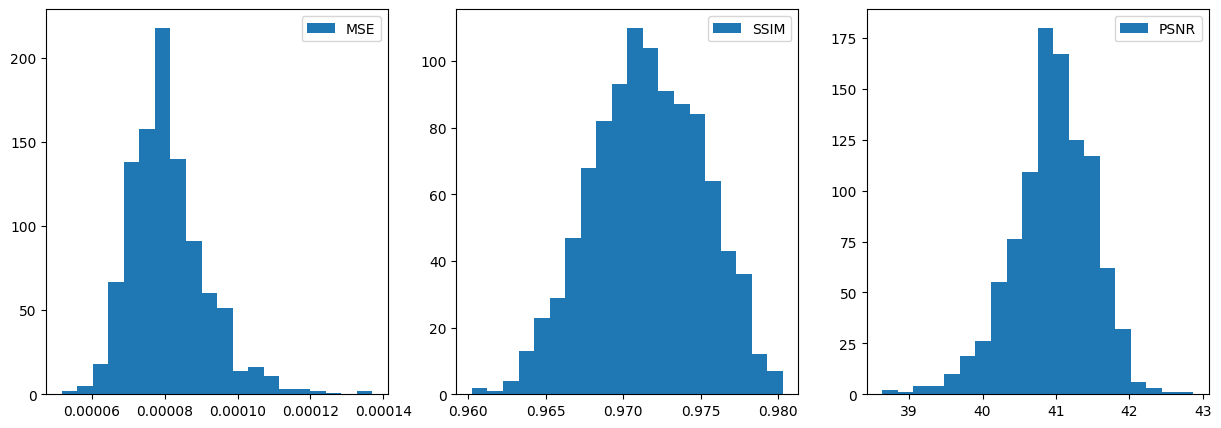

In [10]:
plot, axes = plt.subplots(1,3)
plot.set_size_inches(15,5)
axes[0].hist(history['loss'],20,label="MSE")
axes[1].hist(history['SSIM'],20,label="SSIM")
axes[2].hist(history['PSNR'],20,label="PSNR")
axes[0].legend()
axes[1].legend()
axes[2].legend()

/tmp/ipykernel_2288336/2621650153.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t1 = torch.tensor(LR.view(1,1,75,75))


Text(0.5, 1.0, 'Ground truth')

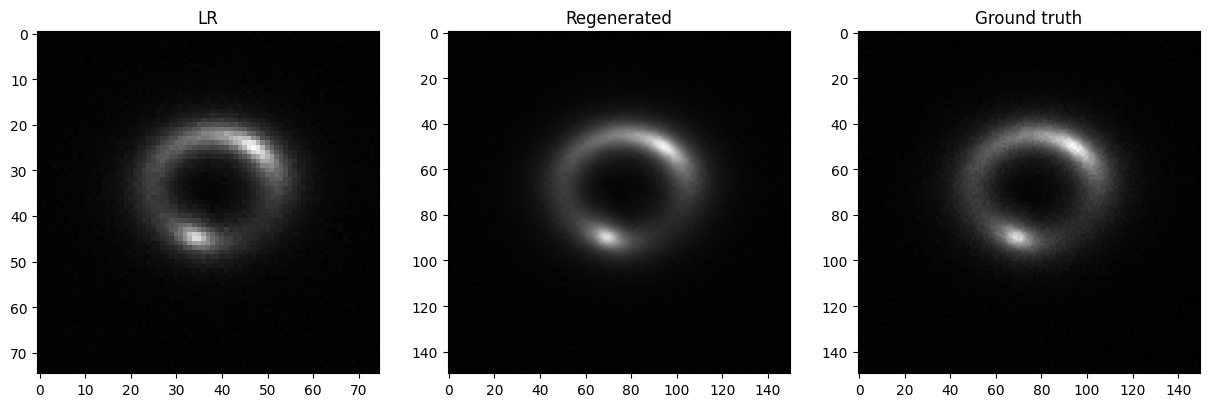

In [14]:
pre, post, tHR = show_random_image(dataset, model, 1000)
plot, axes = plt.subplots(1,3)
plot.set_size_inches(15,5)
axes[0].imshow(pre)
axes[1].imshow(post)
axes[2].imshow(tHR)
axes[0].set_title("LR")
axes[1].set_title("Regenerated")
axes[2].set_title("Ground truth")